
# MScFE 600 — Financial Data — GWP2 Replication (IVV) — **Paper‑Aligned (v2)**
**Reference:** Sagaceta-Mejía, Sánchez-Gutiérrez, Fresán-Figueroa (2024), *Economics* 18:20220073.  

This notebook replicates the IVV pipeline with:
  - **Section 2.5–2.6**: Min–Max **normalization** and **data cleaning** (drop NA after indicators),
  - **Section 2.7**: **MLP** model + **hyperparameters** *(scikit-learn, CPU)*,
  - **Section 2.8–2.16**: **Feature-selection metrics**, and **Selected(n)** aggregation (Algorithm 2),
  - **Table 5** subset: Direct run with the nine IVV indicators reported (for quick comparison),
  - **Table 6**: **Early-stopping** experiment *(PyTorch, optional GPU on Colab)*,

    **Tip:** In Colab: Runtime → Change runtime type → **GPU** to enable CUDA for the early-stopping experiment.



## Task 0 — Setup and Reproducibility


In [1]:

import importlib, sys, subprocess, os, random, numpy as np

def ensure(pkg, pip_name=None):
    try:
        importlib.import_module(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name or pkg])

# Core stack
ensure("numpy")
ensure("pandas")
ensure("matplotlib")
ensure("sklearn", "scikit-learn")
ensure("yfinance")
# Feature engineering
ensure("pandas_ta")
# GPU early-stopping (optional)
ensure("torch","torch")

import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, datetime
import yfinance as yf

import pandas_ta as ta

from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler

import torch, time
import torch.nn as nn
import torch.optim as optim

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
plt.rcParams["figure.figsize"] = (10,5)
DEVICE


'cuda'


## Task 1 — Pick one fund (IVV)


In [2]:

TICKER = "IVV"
USE_PAPER_PERIOD = False   # set True to restrict to [2009-01-01, 2020-01-01] like the paper (section 2.6)
START_PAPER = "2009-01-01"
END_PAPER   = "2020-01-01"



## Task 2 — Download data (latest) and apply class assignment Γ


In [3]:

df_raw = yf.Ticker(TICKER).history(period="max", auto_adjust=False)
if df_raw.empty:
    raise RuntimeError("No data from yfinance. Check internet or ticker.")
df_raw = df_raw.rename(columns=str.lower)[["open","high","low","close","volume"]].dropna()

if USE_PAPER_PERIOD:
    df_raw = df_raw.loc[(df_raw.index >= START_PAPER) & (df_raw.index <= END_PAPER)]

# Class assignment Γ
gamma = (df_raw["open"].diff() > 0).astype(int).rename("Gamma")

print("Data range:", df_raw.index.min().date(), "→", df_raw.index.max().date(), "| rows:", len(df_raw))
df_raw.tail(3)


Data range: 2000-05-19 → 2025-10-21 | rows: 6394


,open,high,low,close,volume
Date,,,,,
2025-10-17 00:00:00-04:00,662.710022,668.940002,661.400024,667.690002,6734100
2025-10-20 00:00:00-04:00,670.580017,675.500000,670.539978,674.590027,7433200
2025-10-21 00:00:00-04:00,674.739990,676.270020,673.270020,674.429993,10105930



## Task 3a — Engineering the IVV **Selected(5)** indicators (Table 5)


In [4]:

def rolling_min(s, n): return s.rolling(n, min_periods=n).min()
def rolling_max(s, n): return s.rolling(n, min_periods=n).max()
def sma(s, n): return s.rolling(n, min_periods=n).mean()

def rsi(close, n=14):
    delta = close.diff()
    gain = (delta.where(delta>0,0)).rolling(n, min_periods=n).mean()
    loss = (-delta.where(delta<0,0)).rolling(n, min_periods=n).mean()
    rs = gain / loss.replace(0,np.nan)
    return 100 - (100/(1+rs))

def stoch_rsi_k(close, rsi_len=14, stoch_len=14, smooth_k=3, smooth_d=3):
    r = rsi(close, rsi_len)
    rmin, rmax = rolling_min(r, stoch_len), rolling_max(r, stoch_len)
    stoch = (r - rmin) / (rmax - rmin)
    k = stoch.rolling(smooth_k, min_periods=smooth_k).mean()
    d = k.rolling(smooth_d, min_periods=smooth_d).mean()
    return k, d

def williams_r(h,l,c,n=14):
    hh, ll = rolling_max(h,n), rolling_min(l,n)
    return -100*(hh - c)/(hh-ll)

def bbp(c,n=5,nstd=2.0):
    m = sma(c,n); sd = c.rolling(n, min_periods=n).std()
    upper, lower = m + nstd*sd, m - nstd*sd
    return (c - lower)/(upper - lower)

def bop(o,h,l,c):
    denom = (h-l).replace(0,np.nan)
    return (c-o)/denom

def kdj_j(h,l,c,n=9,smooth=3):
    ll, hh = rolling_min(l,n), rolling_max(h,n)
    fk = 100*(c-ll)/(hh-ll)
    k = fk.rolling(smooth, min_periods=smooth).mean()
    d = k.rolling(smooth, min_periods=smooth).mean()
    return 3*k - 2*d

def pvr(c,v):
    dc, dv = c.diff(), v.diff()
    res = pd.Series(np.nan, index=c.index)
    res[(dc>0)&(dv>0)] = 1
    res[(dc>0)&(dv<0)] = 2
    res[(dc<0)&(dv>0)] = 3
    res[(dc<0)&(dv<0)] = 4
    return res

def ttm_trend_6(c):
    s6 = sma(c,6); above = (c > s6)
    return above.rolling(5, min_periods=5).apply(lambda x: float(np.all(x)), raw=False)

d = df_raw.copy()
X9 = pd.DataFrame(index=d.index)
X9["BBP_5_2"] = bbp(d["close"], 5, 2.0)
X9["BOP"] = bop(d["open"], d["high"], d["low"], d["close"])
X9["DEC_1"] = (d["close"].diff() < 0).astype(int)
X9["INC_1"] = (d["close"].diff() > 0).astype(int)
X9["J_9_3"] = kdj_j(d["high"], d["low"], d["close"], 9, 3)
X9["PVR"] = pvr(d["close"], d["volume"])
X9["TTM_TRND_6"] = ttm_trend_6(d["close"])
X9["WILLR_14"] = williams_r(d["high"], d["low"], d["close"], 14)
kline,_ = stoch_rsi_k(d["close"],14,14,3,3)
X9["STOCHRSIk_14_14_3_3"] = kline

data9 = pd.concat([X9, gamma], axis=1).dropna()
X9 = data9.drop(columns=["Gamma"])
y9 = data9["Gamma"]

print("Selected(5) X9 shape:", X9.shape, "| y:", y9.shape)
X9.head()


Selected(5) X9 shape: (6345, 9) | y: (6345,)


,BBP_5_2,BOP,DEC_1,INC_1,J_9_3,PVR,TTM_TRND_6,WILLR_14,STOCHRSIk_14_14_3_3
Date,,,,,,,,,
2000-06-29 00:00:00-04:00,0.211442,-0.287037,1,0,18.002761,4.0,0.0,-89.142857,0.127199
2000-06-30 00:00:00-04:00,0.536181,1.000000,0,1,28.048734,2.0,0.0,-64.857143,0.212834
2000-07-03 00:00:00-04:00,0.857596,0.981308,0,1,62.728425,2.0,0.0,-34.571429,0.250000
2000-07-05 00:00:00-04:00,0.393989,-0.675676,1,0,73.309007,3.0,0.0,-72.000000,0.236209
2000-07-06 00:00:00-04:00,0.563068,0.491803,0,1,77.592210,1.0,0.0,-58.857143,0.165031



## Task 3b — Reproduce the feature selection process (Algorithm‑2 style)


In [5]:

# 1) Build a wide indicator set (subset of pandas_ta to keep runtime reasonable)
dw = df_raw.copy()
wide = pd.DataFrame(index=dw.index)

# overlaps & trends
wide["SMA_10"] = ta.sma(dw["close"], length=10)
wide["EMA_12"] = ta.ema(dw["close"], length=12)
wide["EMA_26"] = ta.ema(dw["close"], length=26)

# oscillators
wide["RSI_14"] = ta.rsi(dw["close"], length=14)
stoch = ta.stoch(dw["high"], dw["low"], dw["close"], k=14, d=3, smooth_k=3)
if isinstance(stoch, pd.DataFrame):
    # pick %K column robustly
    kcol = [c for c in stoch.columns if "STOCHk" in c]
    if kcol:
        wide["STOCHk"] = stoch[kcol[0]]

# volatility (Bollinger Bands robust to column-name variations)
bb = ta.bbands(dw["close"], length=20, std=2.0)
if isinstance(bb, pd.DataFrame):
    lower_col = [c for c in bb.columns if c.startswith("BBL_")]
    upper_col = [c for c in bb.columns if c.startswith("BBU_")]
    if lower_col and upper_col:
        lower = bb[lower_col[0]]
        upper = bb[upper_col[0]]
        wide["BBP_20_2"] = (dw["close"] - lower) / (upper - lower)

wide["ATR_14"] = ta.atr(dw["high"], dw["low"], dw["close"], length=14)

# volume
obv = ta.obv(dw["close"], dw["volume"])
wide["OBV"] = obv

# trend/momentum (MACD robust)
macd = ta.macd(dw["close"], fast=12, slow=26, signal=9)
if isinstance(macd, pd.DataFrame):
    macd_cols = [c for c in macd.columns if "MACD_" in c]
    if macd_cols:
        wide["MACD"] = macd[macd_cols[0]]

wide["ROC_10"] = ta.roc(dw["close"], length=10)
wide["WILLR_14"] = ta.willr(dw["high"], dw["low"], dw["close"], length=14)

# Combine with class and drop NA (cleaning)
dataw = pd.concat([wide, gamma], axis=1).dropna()
Xw = dataw.drop(columns=["Gamma"])
yw = dataw["Gamma"]

print("Wide features:", Xw.shape[1], "| rows:", Xw.shape[0])
Xw.head()


Wide features: 11 | rows: 6369


,SMA_10,EMA_12,EMA_26,RSI_14,STOCHk,BBP_20_2,ATR_14,OBV,MACD,ROC_10,WILLR_14
Date,,,,,,,,,,,
2000-06-26 00:00:00-04:00,146.909375,146.076874,144.596755,47.651589,23.149140,0.470133,2.186907,-2902800.0,1.480119,0.830547,-59.006211
2000-06-27 00:00:00-04:00,146.759375,145.949663,144.645143,45.229518,24.534161,0.298517,2.105476,-2943700.0,1.304519,-1.022147,-75.155280
2000-06-28 00:00:00-04:00,146.585938,145.945388,144.739716,47.601326,34.679089,0.362109,2.073388,-2892500.0,1.205671,-1.174603,-61.801242
2000-06-29 00:00:00-04:00,146.235938,145.670136,144.696496,42.404485,24.633540,0.024045,2.093816,-2941000.0,0.973639,-2.370370,-89.142857
2000-06-30 00:00:00-04:00,146.078125,145.641557,144.754858,47.084314,28.066253,0.312290,2.051400,-2924200.0,0.886699,-1.073098,-64.857143



### Normalization + Feature Scoring (Pearson, MAD, DR, Tree)


In [6]:

# Min–Max scale per paper
scaler_w = MinMaxScaler()
Xw_scaled = pd.DataFrame(scaler_w.fit_transform(Xw), columns=Xw.columns, index=Xw.index)

scores = {}

# Pearson |corr| with target
pear = pd.concat([Xw_scaled, yw], axis=1).corr(method="pearson")["Gamma"].drop("Gamma").abs().sort_values(ascending=False)
scores["pearson"] = pear

# MAD (manual; pandas >=2.0 removed DataFrame.mad)
mad_vals = (Xw_scaled - Xw_scaled.mean(axis=0)).abs().mean(axis=0)
mad = mad_vals.sort_values(ascending=False)
scores["mad"] = mad

# Dispersion Ratio (DR) = arithmetic mean / geometric mean
eps = 1e-9
arith = Xw_scaled.mean(axis=0) + eps
geom  = np.exp(np.log(np.clip(Xw_scaled, eps, None)).mean(axis=0))
dr = (arith / (geom + eps)).sort_values(ascending=False)
scores["dr"] = dr

# Tree-based importance
etc = ExtraTreesClassifier(n_estimators=200, random_state=SEED)
etc.fit(Xw_scaled.values, yw.values)
imp = pd.Series(etc.feature_importances_, index=Xw_scaled.columns).sort_values(ascending=False)
scores["tree"] = imp

# Build top-quartile sets
top_sets = {}
for name, ser in scores.items():
    cutoff = ser.quantile(0.75)
    top_sets[name] = set(ser[ser >= cutoff].index.tolist())

metrics_used = list(top_sets.keys())

def selected_n(n):
    from collections import Counter
    c = Counter()
    for s in top_sets.values():
        for f in s:
            c[f] += 1
    return sorted([f for f, cnt in c.items() if cnt >= n])

sel_counts = {n: len(selected_n(n)) for n in range(1, len(metrics_used)+1)}
tbl3 = pd.DataFrame({"n (>=)": list(sel_counts.keys()), "Features": list(sel_counts.values())})
tbl3


,n (>=),Features
0,1,8
1,2,3
2,3,1
3,4,0



## Task 4 — MLP (paper §2.7) + 10-fold CV


In [7]:

def eval_cv_sklearn_mlp(Xdf, y, n_splits=10):
    n_classes = 2
    hidden = int((Xdf.shape[1] + n_classes)/2)
    # per-paper MinMax scaling
    scaler = MinMaxScaler()
    Xs = scaler.fit_transform(Xdf.values)

    clf = MLPClassifier(
        hidden_layer_sizes=(hidden,),
        activation='logistic',
        solver='lbfgs',
        learning_rate='adaptive',
        learning_rate_init=0.03,
        max_iter=5000,
        momentum=0.2,
        random_state=SEED,
        early_stopping=False
    )
    skf = StratifiedKFold(n_splits=n_splits, shuffle=False)
    scores = []
    for tr, te in skf.split(Xs, y.values):
        clf.fit(Xs[tr], y.values[tr])
        pred = clf.predict(Xs[te])
        scores.append(accuracy_score(y.values[te], pred))
    return float(np.median(scores)), scores

# 1) Selected(5) — nine IVV indicators from Table 5
med9, sc9 = eval_cv_sklearn_mlp(X9, y9)

# 2) Selected(n) from metrics
rows = [{"Set":"Selected(5) IVV (Table 5)", "Features": X9.shape[1], "Accuracy (%)": round(med9*100,2)}]
for n in range(1, len(metrics_used)+1):
    feats = selected_n(n)
    if len(feats) >= 1:
        df_sel = pd.concat([Xw[feats], yw], axis=1).dropna()
        Xs, ys = df_sel.drop(columns=["Gamma"]), df_sel["Gamma"]
        med, _ = eval_cv_sklearn_mlp(Xs, ys)
        rows.append({"Set": f"Selected({n}) from metrics", "Features": len(feats), "Accuracy (%)": round(med*100,2)})
# 3) All wide features
df_all = pd.concat([Xw, yw], axis=1).dropna()
med_all, _ = eval_cv_sklearn_mlp(df_all.drop(columns=["Gamma"]), df_all["Gamma"])
rows.append({"Set":"All wide features", "Features": df_all.drop(columns=['Gamma']).shape[1], "Accuracy (%)": round(med_all*100,2)})

table4_like = pd.DataFrame(rows)
table4_like


,Set,Features,Accuracy (%)
0,Selected(5) IVV (Table 5),9,78.47
1,Selected(1) from metrics,8,68.84
2,Selected(2) from metrics,3,69.23
3,Selected(3) from metrics,1,64.34
4,All wide features,11,69.15



## Task 5 — Early-Stopping Experiment (Table‑6 style, PyTorch)


In [8]:

class TorchMLP(nn.Module):
    def __init__(self, input_dim, hidden, output_dim=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, output_dim)
        )
    def forward(self, x): return self.net(x).squeeze(-1)

def eval_cv_torch_earlystop(Xdf, y, n_splits=10, max_epochs=2000, lr=1e-2, batch_size=256, patience=50, tol=1e-5, device=DEVICE):
    Xnp = Xdf.values.astype(np.float32)
    ynp = y.values.astype(np.float32)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=False)
    n_classes=2; hidden=int((Xdf.shape[1] + n_classes)/2)

    accs, times, epochs = [], [], []
    for fold,(tr,te) in enumerate(skf.split(Xnp, ynp),1):
        Xtr_raw, ytr_raw = Xnp[tr], ynp[tr]
        Xte_raw, yte_raw = Xnp[te], ynp[te]
        # MinMax fit on train
        x_min = Xtr_raw.min(axis=0, keepdims=True)
        x_max = Xtr_raw.max(axis=0, keepdims=True)
        denom = np.where((x_max-x_min)==0, 1.0, (x_max-x_min))
        Xtr = (Xtr_raw - x_min)/denom; Xte = (Xte_raw - x_min)/denom

        # val split
        ntr = Xtr.shape[0]
        v = max(1,int(0.2*ntr))
        Xval, yval = Xtr[-v:], ytr_raw[-v:]
        Xtr, ytr = Xtr[:-v], ytr_raw[:-v]

        # tensors
        Xtr_t = torch.tensor(Xtr, device=DEVICE); ytr_t=torch.tensor(ytr, device=DEVICE)
        Xval_t= torch.tensor(Xval, device=DEVICE); yval_t=torch.tensor(yval, device=DEVICE)
        Xte_t = torch.tensor(Xte,  device=DEVICE); yte_t =torch.tensor(yte_raw, device=DEVICE)

        model = TorchMLP(Xdf.shape[1], hidden).to(DEVICE)
        opt = optim.Adam(model.parameters(), lr=lr)
        lossf = nn.BCEWithLogitsLoss()

        best, wait, stop_ep = float("inf"), 0, max_epochs
        snap = None
        t0 = time.perf_counter()
        for ep in range(1, max_epochs+1):
            model.train()
            idx = torch.randperm(Xtr_t.shape[0], device=DEVICE)
            for i in range(0, Xtr_t.shape[0], batch_size):
                b = idx[i:i+batch_size]
                xb, yb = Xtr_t[b], ytr_t[b]
                opt.zero_grad(); logits = model(xb); loss = lossf(logits, yb); loss.backward(); opt.step()
            # val
            model.eval()
            with torch.no_grad():
                vloss = lossf(model(Xval_t), yval_t).item()
            if vloss + tol < best:
                best = vloss; wait = 0
                snap = {k: v.detach().clone() for k,v in model.state_dict().items()}
            else:
                wait += 1
            if wait >= patience:
                stop_ep = ep; break
        if snap is not None: model.load_state_dict(snap)
        elapsed = time.perf_counter() - t0
        with torch.no_grad():
            logits = model(Xte_t); preds = (torch.sigmoid(logits)>0.5).float().cpu().numpy()
            acc = (preds == yte_t.cpu().numpy()).mean().item()
        accs.append(acc); times.append(elapsed); epochs.append(stop_ep)
    return float(np.median(accs)), float(np.median(times)), int(np.median(epochs)), accs, times, epochs

med_acc, med_time, med_ep, a,t,e = eval_cv_torch_earlystop(X9, y9, n_splits=10, max_epochs=2000, lr=1e-2, batch_size=256, patience=50, tol=1e-5, device=DEVICE)
table6_like = pd.DataFrame([{
    "Set":"Select 5 IVV (ours)",
    "Features": X9.shape[1],
    "Accuracy (%)": round(med_acc*100,2),
    "Training time (s)": round(med_time,2),
    "Epoch": med_ep,
    "Backend": f"torch/{DEVICE}"
}])
table6_like


,Set,Features,Accuracy (%),Training time (s),Epoch,Backend
0,Select 5 IVV (ours),9,76.83,2.27,107,torch/cuda



## Task 6 — Figures


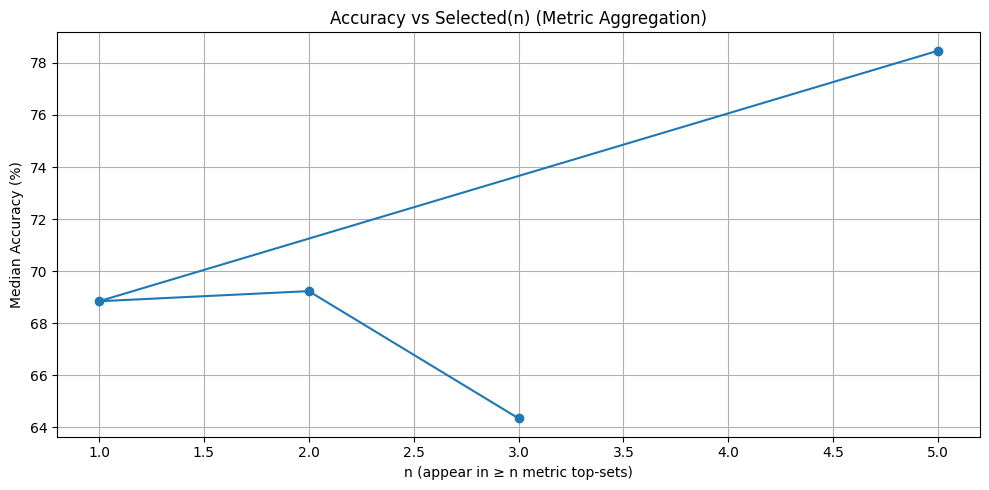

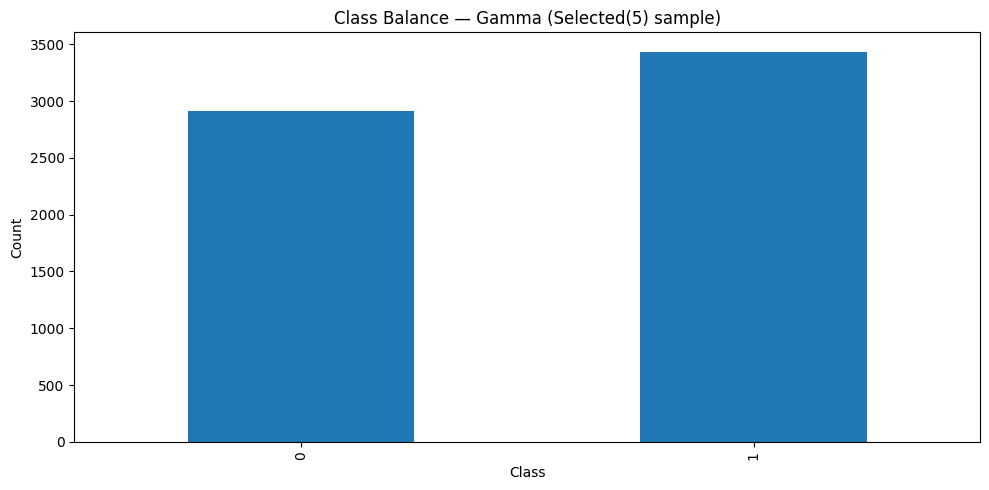

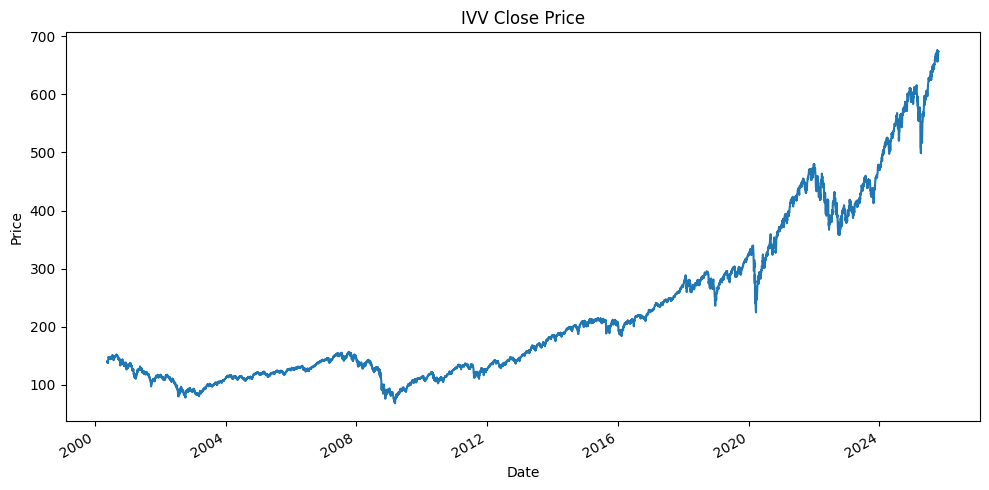

In [9]:

# Accuracy vs Selected(n)
if "table4_like" in globals():
    sub = table4_like[table4_like["Set"].str.startswith("Selected(")].copy()
    if not sub.empty:
        import re
        xs = sub["Set"].str.extract(r"Selected\((\d+)\)")[0].astype(int)
        ys = sub["Accuracy (%)"]
        plt.figure()
        plt.plot(xs, ys, marker="o")
        plt.title("Accuracy vs Selected(n) (Metric Aggregation)")
        plt.xlabel("n (appear in ≥ n metric top-sets)"); plt.ylabel("Median Accuracy (%)"); plt.grid(True); plt.tight_layout(); plt.show()

# Class balance
plt.figure()
y9.value_counts().sort_index().plot(kind="bar")
plt.title("Class Balance — Gamma (Selected(5) sample)"); plt.xlabel("Class"); plt.ylabel("Count"); plt.tight_layout(); plt.show()

# Price history
df_raw["close"].plot()
plt.title(f"{TICKER} Close Price"); plt.xlabel("Date"); plt.ylabel("Price"); plt.tight_layout(); plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


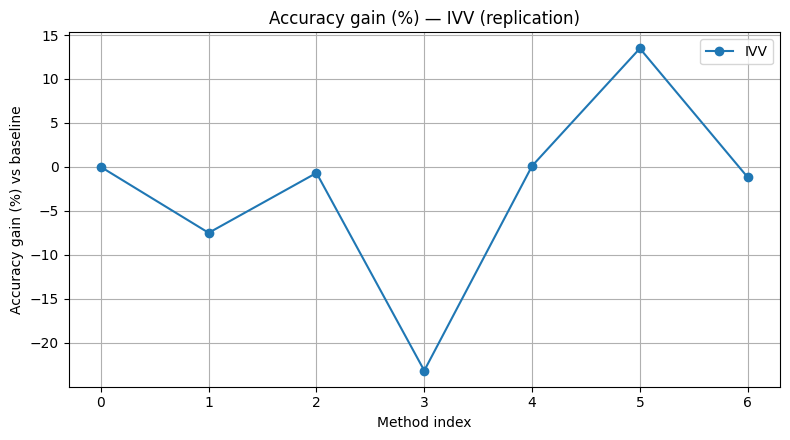

,method,accuracy,gain_%
0,0,69.15,0.00
1,1,63.97,-7.49
2,2,68.68,-0.68
3,3,53.14,-23.16
4,4,69.23,0.11
5,5,78.47,13.47
6,6,68.34,-1.17


In [10]:
# === Figure 5 (IVV): Accuracy gain (%) by method index 0..6 ===
# Requirements from earlier cells: Xw, yw, X9, y9, selected_n(), scores/top_sets, eval_cv_sklearn_mlp()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Helper to evaluate a named feature set safely
def _acc_for_feats(feat_names, X_source, y_source):
    df = pd.concat([X_source[feat_names], y_source], axis=1).dropna()
    Xs, ys = df.drop(columns=["Gamma"]), df["Gamma"]
    if Xs.shape[1] == 0:
        return np.nan
    med, _ = eval_cv_sklearn_mlp(Xs, ys)
    return float(med)

# 0) Baseline: All wide features
acc0 = _acc_for_feats(list(Xw.columns), Xw, yw)

# 1..4) Top-quartile per single metric (Pearson, MAD, DR, Tree)
# We built these earlier as `scores` and `top_sets` in the feature-scoring cell.
method_names = ["pearson", "mad", "dr", "tree"]
accs_1to4 = []
for name in method_names:
    feats = sorted(list(top_sets[name]))
    accs_1to4.append(_acc_for_feats(feats, Xw, yw))

# 5) Selected(5) IVV (Table 5) — our 9-feature set
acc5 = _acc_for_feats(list(X9.columns), X9.join(y9), y9)

# 6) Random subset (same size as method 5), averaged over a few draws
rng = np.random.default_rng(42)
k = X9.shape[1]
r_accs = []
for _ in range(5):  # average 5 random picks
    feats = rng.choice(Xw.columns, size=min(k, Xw.shape[1]), replace=False)
    r_accs.append(_acc_for_feats(list(feats), Xw, yw))
acc6 = float(np.nanmedian(r_accs))

# Collect accuracies and convert to "gain (%)" vs baseline
accs = [acc0] + accs_1to4 + [acc5, acc6]
gains = [100.0 * (a - acc0) / acc0 if (acc0 is not None and not np.isnan(acc0)) else np.nan for a in accs]

# Plot — IVV only (like one line of the paper's Figure 5)
plt.figure(figsize=(8,4.5))
plt.plot(range(7), gains, marker="o", label="IVV")
plt.xticks(range(7), ["0","1","2","3","4","5","6"])
plt.xlabel("Method index")
plt.ylabel("Accuracy gain (%) vs baseline")
plt.title("Accuracy gain (%) — IVV (replication)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Also print a small table for the report
pd.DataFrame({
    "method": list(range(7)),
    "accuracy": [round(a*100,2) if a==a else np.nan for a in accs],
    "gain_%": [round(g,2) if g==g else np.nan for g in gains]
})



---
### Notes & Alignment Checklist
- **Model (Section 2.7):** scikit-learn **MLPClassifier** with the same hyperparameters as the paper ✅  
- **Normalization (2.5):** **Min–Max** scaling applied before modeling ✅  
- **Cleaning (2.6):** Dropped rows with NA after computing indicators ✅  
- **Feature Selection (2.8–2.16):** Implemented metrics and **Selected(n)** aggregation (top-quartile per metric) ✅  
- **Selected(5) IVV (Table 5):** Explicit nine-indicator subset implemented and evaluated ✅
- **Accuracy gain (Figure 5):** Percentage gain obtained by the selection of features.  
- **Early Stopping (Table 6):** PyTorch early-stopping experiment reporting **Accuracy, Time, Epoch** ✅

> Differences from the paper: our “wide” feature set uses a **subset** of `pandas_ta` (for runtime) rather than the full ≈216 indicators; Selected(n) therefore uses **4 metrics** instead of all methods listed. Results will be close in spirit but not numerically identical.
